In [55]:
import torch
from torch.utils.data import DataLoader
from torch.functional import F
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [56]:
data_dir = '../data/'
valid_dir = data_dir + 'images/valid/'

class AddRandomNoise(v2.Transform):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        noise = torch.randn(img.size()) * self.std + self.mean
        return img + noise

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    AddRandomNoise(mean=0.0, std=0.05),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_set = ImageFolder(valid_dir, transform=transform, target_transform=None)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

In [57]:
model = torch.load('../models/ResNet18_pretrained-epoch14-batch_size32-lr0.000125-loss0.2268.pt')
model.eval();
device = next(model.parameters()).device.type

In [58]:
pred = []
true = []
probs = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        pred += predicted.cpu().numpy().tolist()
        true += labels.numpy().tolist()
        probs += F.softmax(output, dim=1).cpu().numpy().tolist()

probs = np.array(probs)
pred = np.array(pred)
true = np.array(true)

accuracy = (true == pred).sum() / len(true)
print(f'Test Accuracy: {accuracy:.2%}')

Test Accuracy: 97.48%


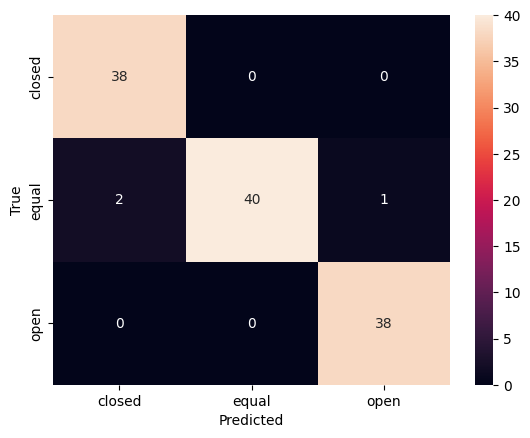

In [59]:
class_to_idx = valid_set.class_to_idx
labels = [k for k, _ in sorted(class_to_idx.items(), key=lambda item: item[1])]

cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Class 0 AUC-ROC: 1.0000


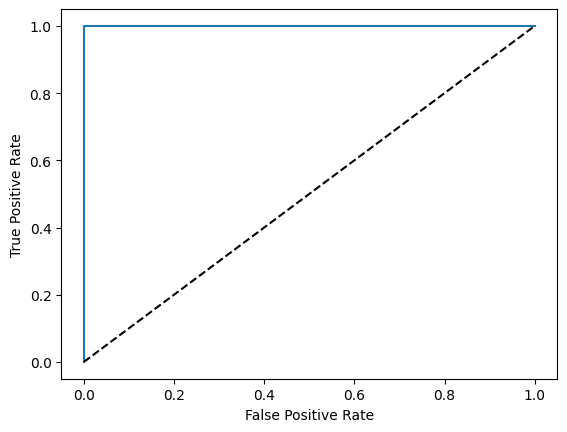

Class 1 AUC-ROC: 0.9991


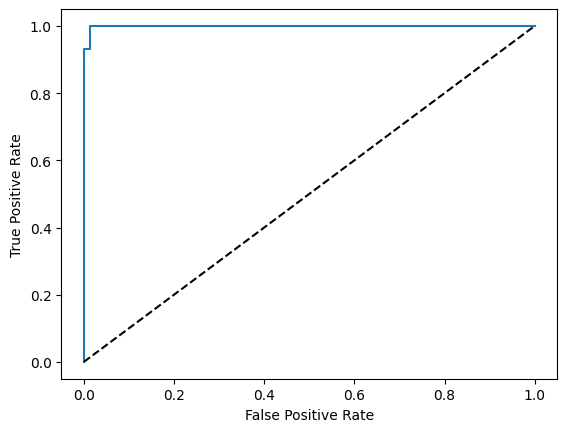

Class 2 AUC-ROC: 0.9997


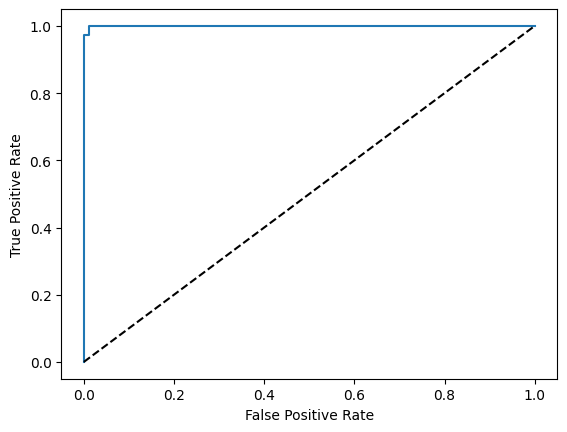

Average AUC-ROC: 0.9995


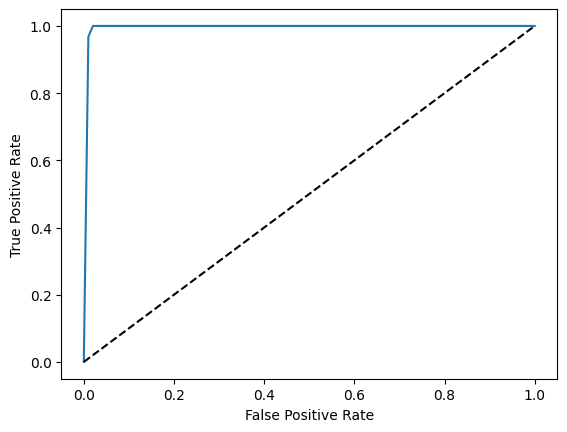

In [60]:
### OvR ROC ###

for i in range(probs.shape[1]):
    fpr, tpr, _ = roc_curve(true == i, probs[:, i])

    auc_roc = auc(fpr, tpr)
    print(f'Class {i} AUC-ROC: {auc_roc:.4f}')

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### OvR average ROC ###

fpr = []
tpr = []
for i in range(probs.shape[1]):
    ovr_fpr, ovr_tpr, _ = roc_curve(true == i, probs[:, i])
    fpr.append(ovr_fpr)
    tpr.append(ovr_tpr)

fpr_grid = np.linspace(0.0, 1.0, 100)

# Interpolate ROC curves
mean_tpr = np.zeros_like(fpr_grid)
for i in range(probs.shape[1]):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= probs.shape[1]

auc_roc = auc(fpr_grid, mean_tpr)
print(f'Average AUC-ROC: {auc_roc:.4f}')

mean_tpr[0] = 0.0
plt.plot(fpr_grid, mean_tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()